In [60]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, AdaBoostClassifier, VotingClassifier
import xgboost as xgb
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score
from imblearn.over_sampling import SMOTE

In [61]:
X_train_csv = pd.read_csv('X_train.csv')
y_train_csv = pd.read_csv('y_train.csv')
X_test_csv = pd.read_csv('X_test.csv')

X_train_csv.set_index('Unnamed: 0', inplace=True)
y_train_csv.set_index('Unnamed: 0', inplace=True)

## Pipline

In [62]:
NUM_COLS = ['JoiningYear', 'Age', 'ExperienceInCurrentDomain']
CAT_COLS = ['Education', 'City', 'PaymentTier', 'Gender', 'EverBenched', 'Race']

numeric_transformer = Pipeline(steps=[('imputer_num', SimpleImputer(strategy="mean")),
                                      ('scaler', StandardScaler())])


categorical_transformer = Pipeline(steps=[('imputer_cat', SimpleImputer(strategy="most_frequent")),
                                          ('onehot', OneHotEncoder())])

# Combine transformers using ColumnTransformer
column_transformer = ColumnTransformer(transformers=[('num', numeric_transformer, NUM_COLS),
                                                     ('cat', categorical_transformer, CAT_COLS)])

# The final pipeline
preprocess_pipeline = Pipeline(steps=[ # ('set_id_index', func_set_index),
                                       # ('func_drop_col', func_drop_col),
                                      ('col_transformer', column_transformer)])
                                  
preprocess_pipeline

Pipeline(steps=[('col_transformer',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer_num',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['JoiningYear', 'Age',
                                                   'ExperienceInCurrentDomain']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer_cat',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder())]),
                                                  ['Education', 'City',
                                                   'PaymentTier', 'Gender',
                                                   'EverBenched', 'Race'])]))])

## Apply SMOTE on the data

In [5]:
X_proc = column_transformer.fit_transform(X_train_csv, y_train_csv)

smote = SMOTE(random_state=123)

X_smote, y_smote = smote.fit_resample(X_proc, y_train_csv)


y_df = pd.DataFrame(y_smote)
# Get the feature names for categorical columns after one-hot encoding
one_hot_feature_names = column_transformer.named_transformers_['cat']['onehot'].get_feature_names_out(CAT_COLS)
# Combine with the numerical column names
all_feature_names = NUM_COLS + list(one_hot_feature_names)
X_df = pd.DataFrame(X_smote, columns=all_feature_names)

data_with_smote = X_df.join(y_df)

# train test split
X = data_with_smote.drop('LeaveOrNot', axis=1)
y = data_with_smote['LeaveOrNot']

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=0)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((3864, 20), (966, 20), (3864,), (966,))

In [6]:
# Clasiffiers with grid search to find the best model

def train_classifier(clf, param_grid, X_train, y_train):
    gs = GridSearchCV(clf, param_grid=param_grid, cv=10, scoring='f1')
    gs.fit(X_train, y_train)

    best_clf = gs.best_estimator_
    best_params = gs.best_params_
    best_f1_score = gs.best_score_

    print(f"Best {clf.__class__.__name__} f1 score:", best_f1_score)
    print(f"Best {clf.__class__.__name__} Parameters:", best_params)

    return best_clf, best_params, best_f1_score

In [40]:
# Confusion matrix and Classification Report function

def evaluate_and_plot(clf, X_test, y_test, class_labels):
    # Make predictions using the best estimator
    y_pred = clf.predict(X_test)

    # Evaluate the model using confusion matrix
    conf_matrix = confusion_matrix(y_test, y_pred)
    
    # Plot the confusion matrix
    plt.figure(figsize=(4, 2))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=class_labels, yticklabels=class_labels)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

    # Classification Report
    class_report = classification_report(y_test, y_pred)
    print("Classification Report:\n", class_report)

    return conf_matrix, class_report

## **Decision Tree Classifier**

In [7]:
dt_clf = DecisionTreeClassifier(random_state=42)
dt_param_grid = {'max_depth': [10, 25, 50],
                 'min_samples_leaf': [5, 10, 20],
                 'min_samples_split': [15, 20, 50]}
best_dt_clf, best_dt_params, best_dt_f1_score = train_classifier(dt_clf, dt_param_grid, X_train, y_train)

Best DecisionTreeClassifier f1 score: 0.8199234600605265
Best DecisionTreeClassifier Parameters: {'max_depth': 25, 'min_samples_leaf': 5, 'min_samples_split': 15}


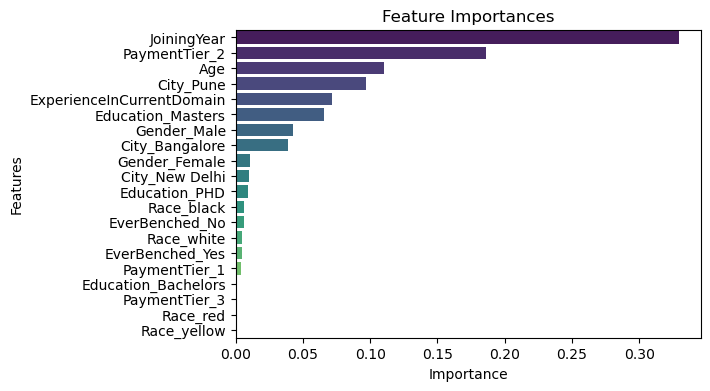

In [10]:
# DT feature importance
feature_importances = pd.Series(best_dt_clf.feature_importances_ , index=X_train.columns) 
sort_features = feature_importances.sort_values(ascending=False)

plt.figure(figsize=(6, 4))
sns.barplot(x=sort_features.values, y=sort_features.index, palette="viridis")
plt.title('Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.show()

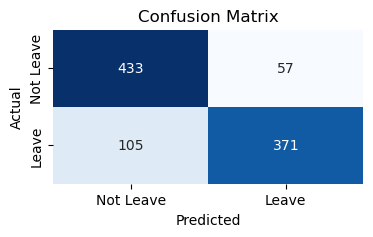

Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.88      0.84       490
           1       0.87      0.78      0.82       476

    accuracy                           0.83       966
   macro avg       0.84      0.83      0.83       966
weighted avg       0.84      0.83      0.83       966



In [32]:
# Confusion matrix and Classification Report

conf_matrix_dt, class_report_dt = evaluate_and_plot(best_dt_clf, X_test, y_test, ['Not Leave', 'Leave'])

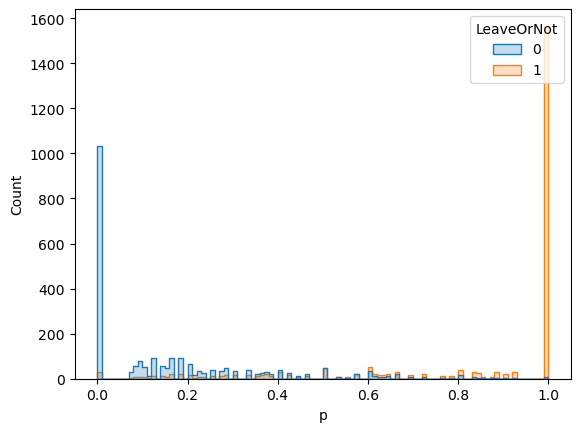

In [12]:
# Illustrative of the probability to leave or not

y_proba_dt = best_dt_clf.predict_proba(X)

leave_probs = pd.DataFrame(y_proba_dt,
                         columns=[f'P({x})' for x in best_dt_clf.classes_],
                         index=data_with_smote.index)
data_joined = data_with_smote.join(leave_probs)

df = {"p":data_joined["P(1)"].tolist(),
      "LeaveOrNot" :data_joined['LeaveOrNot']};

ax = sns.histplot(df, x="p", hue="LeaveOrNot",bins=100, element="step")

## Ada Boost Classifier

In [14]:
adb_clf = AdaBoostClassifier(estimator=best_dt_clf)
adb_param_grid = {'n_estimators': [10, 50, 100],
                  'learning_rate': [0.1, 0.5, 1]}
best_ada_clf, best_ada_params, best_ada_f1_score = train_classifier(adb_clf, adb_param_grid, X_train, y_train)

Best AdaBoostClassifier f1 score: 0.8465447925089885
Best AdaBoostClassifier Parameters: {'learning_rate': 1, 'n_estimators': 100}


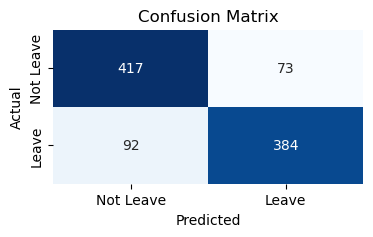

Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.85      0.83       490
           1       0.84      0.81      0.82       476

    accuracy                           0.83       966
   macro avg       0.83      0.83      0.83       966
weighted avg       0.83      0.83      0.83       966



In [33]:
# Confusion matrix and Classification Report

conf_matrix_adb, class_report_adb = evaluate_and_plot(best_ada_clf, X_test, y_test, ['Not Leave', 'Leave'])

## **Random Forest**

In [15]:
rf_clf = RandomForestClassifier(random_state=42)
rf_param_grid = {'n_estimators': [50, 100, 200],
                 'max_depth': [15, 10, 25, 50],
                 'min_samples_leaf': [20, 5, 10, 20],
                 'min_samples_split': [10, 15, 20, 50]}
best_rf_clf, best_rf_params, best_rf_f1_score = train_classifier(rf_clf, rf_param_grid, X_train, y_train)

Best RandomForestClassifier f1 score: 0.8257720438031736
Best RandomForestClassifier Parameters: {'max_depth': 15, 'min_samples_leaf': 5, 'min_samples_split': 15, 'n_estimators': 200}


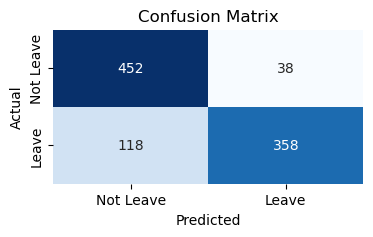

Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.92      0.85       490
           1       0.90      0.75      0.82       476

    accuracy                           0.84       966
   macro avg       0.85      0.84      0.84       966
weighted avg       0.85      0.84      0.84       966



In [34]:
# Confusion matrix and Classification Report

conf_matrix_rf, class_report_rf = evaluate_and_plot(best_rf_clf, X_test, y_test, ['Not Leave', 'Leave'])

## XG Boost Classifier

In [75]:
# Smaller values of "min_child_weight" allow the algorithm to create deeper trees,
# potentially capturing more intricate patterns in the training data.
# If the value is too high, the algorithm may underfit the data,
# and if it's too low, the model may become overly complex and overfit.


xgb_clf = xgb.XGBClassifier(estimator=best_dt_clf, objective="binary:hinge", random_state=42)
xgb_param_grid = {'n_estimators': [100, 200, 300],
                  'learning_rate': [0.01, 0.1, 1],
                  'max_depth': [3, 4, 5],
                  'min_child_weight': [1, 2, 6]}
                 # 'gamma': [0.1],
                 # 'subsample': [0.9, 1.0],
                 # 'colsample_bytree': [0.8, 0.9]
best_xgb_clf, best_xgb_params, best_xgb_f1_score = train_classifier(xgb_clf, xgb_param_grid, X_train, y_train)

C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [19:52:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [19:52:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [19:52:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: Use

C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [19:52:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [19:52:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [19:52:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: Use

C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [19:52:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [19:52:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [19:52:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: Use

C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [19:52:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [19:52:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [19:52:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: Use

C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [19:52:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [19:52:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [19:52:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: Use

C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [19:52:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [19:52:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [19:52:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: Use

C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [19:52:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [19:52:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [19:52:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: Use

C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [19:52:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [19:52:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [19:52:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: Use

C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [19:52:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [19:52:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [19:52:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: Use

C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [19:52:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [19:52:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [19:52:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: Use

C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [19:53:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [19:53:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [19:53:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: Use

C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [19:53:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [19:53:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [19:53:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: Use

C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [19:53:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [19:53:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [19:53:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: Use

C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [19:53:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [19:53:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [19:53:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: Use

C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [19:53:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [19:53:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [19:53:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: Use

C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [19:53:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [19:53:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [19:53:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: Use

C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [19:53:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [19:53:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [19:53:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: Use

C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [19:53:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [19:53:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [19:53:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: Use

C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [19:53:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [19:53:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [19:53:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: Use

C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [19:53:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [19:53:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [19:53:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: Use

C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [19:53:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [19:53:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [19:53:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: Use

C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [19:54:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [19:54:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [19:54:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: Use

C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [19:54:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [19:54:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [19:54:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: Use

C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [19:54:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [19:54:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [19:54:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: Use

C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [19:54:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [19:54:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [19:54:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: Use

C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [19:54:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [19:54:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [19:54:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: Use

C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [19:54:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [19:54:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [19:54:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: Use

C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [19:54:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [19:54:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [19:54:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: Use

C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [19:54:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [19:54:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [19:54:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: Use

C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [19:54:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [19:54:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [19:54:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: Use

Best XGBClassifier f1 score: 0.8568995466616217
Best XGBClassifier Parameters: {'learning_rate': 0.1, 'max_depth': 4, 'min_child_weight': 2, 'n_estimators': 250}


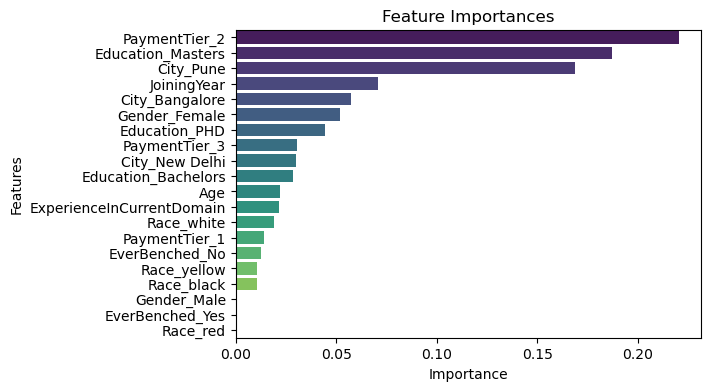

In [23]:
feature_importances = pd.Series(best_xgb_clf.feature_importances_ , index=X_train.columns) 

sort_features = feature_importances.sort_values(ascending=False)

plt.figure(figsize=(6, 4))
sns.barplot(x=sort_features.values, y=sort_features.index, palette="viridis")
plt.title('Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.show()

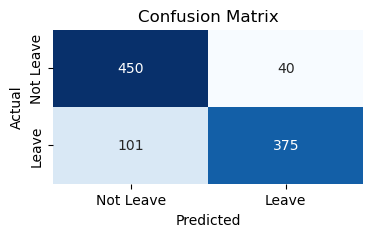

Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.92      0.86       490
           1       0.90      0.79      0.84       476

    accuracy                           0.85       966
   macro avg       0.86      0.85      0.85       966
weighted avg       0.86      0.85      0.85       966



In [74]:
conf_matrix_xgb, class_report_xgb = evaluate_and_plot(best_xgb_clf, X_test, y_test, ['Not Leave', 'Leave'])

## **Logistic Regression Model**

In [27]:
# # C= Regularization Strength. a large 'C' means you want a smoother curve that captures
# # the general trend without fitting each point precisely
# # tol= Tolerance for Stopping Criteria. A larger 'tol' means you're willing to stop
# # when you are reasonably close, even if you haven't found the absolute best solution.

lr_model = LogisticRegression()
lr_params_grid = {'C': [1, 5, 10],
                  'tol': [0.001, 0.0001, 0.00001]}
                  # 'penalty': ['l1', 'l2']
best_lr_clf, best_lr_params, best_lr_f1_score = train_classifier(lr_model, lr_params_grid, X_train, y_train)

Best LogisticRegression f1 score: 0.6892418363839445
Best LogisticRegression Parameters: {'C': 5, 'tol': 0.001}


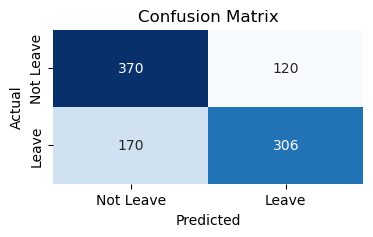

Classification Report:
               precision    recall  f1-score   support

           0       0.69      0.76      0.72       490
           1       0.72      0.64      0.68       476

    accuracy                           0.70       966
   macro avg       0.70      0.70      0.70       966
weighted avg       0.70      0.70      0.70       966



In [36]:
# Confusion matrix and Classification Report

conf_matrix_lr, class_report_lr = evaluate_and_plot(best_lr_clf, X_test, y_test, ['Not Leave', 'Leave'])

## ROC - AUC

Decision Tree: 0.89
Random Forest: 0.91
Logistic Regression: 0.74
Ada Boost: 0.91
XG Boost: 0.86


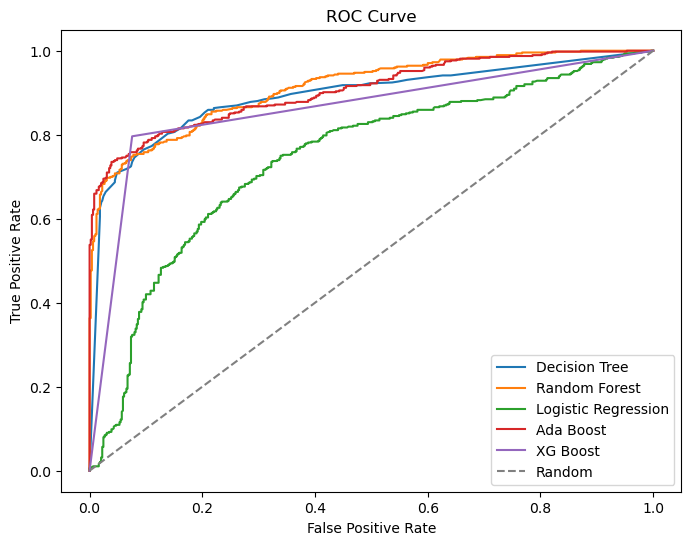

In [72]:
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# Define classifiers and their best models
classifiers = ['Decision Tree', 'Random Forest', 'Logistic Regression', 'Ada Boost', 'XG Boost']
best_clfs = [best_dt_clf, best_rf_clf, best_lr_clf, best_ada_clf, best_xgb_clf]

# Initialize lists to store AUC values and ROC curves
auc_values = []
fpr_values = []
tpr_values = []

# Loop through classifiers
for clf, name in zip(best_clfs, classifiers):
    # Calculate predicted probabilities
    y_proba = clf.predict_proba(X_test)[:, 1]

    # Calculate AUC
    auc = roc_auc_score(y_test, y_proba)
    auc_values.append(auc)

    # Calculate ROC Curve
    fpr, tpr, thresholds = roc_curve(y_test, y_proba)
    fpr_values.append(fpr)
    tpr_values.append(tpr)

    # Print AUC evaluation
    print(f"{name}: {auc:.2f}")

# Plot ROC Curves
plt.figure(figsize=(8, 6))
for name, fpr, tpr, auc in zip(classifiers, fpr_values, tpr_values, auc_values):
    plt.plot(fpr, tpr, label=f'{name}') #(AUC = {auc:.2f})')

plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

## Voting

In [37]:
# Soft Voting- The predicted class is the one with the highest summed probability across all classifiers.
# the classifier sums up the predicted probabilities for each class from individual classifiers and selects the class
# with the highest sum.

voting_clf = VotingClassifier(estimators= [('best_dt_clf', best_dt_clf), ('best_rf_clf', best_rf_clf)], voting= 'soft')

voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('best_dt_clf',
                              DecisionTreeClassifier(max_depth=25,
                                                     min_samples_leaf=5,
                                                     min_samples_split=15,
                                                     random_state=42)),
                             ('best_rf_clf',
                              RandomForestClassifier(max_depth=15,
                                                     min_samples_leaf=5,
                                                     min_samples_split=15,
                                                     n_estimators=200,
                                                     random_state=42))],
                 voting='soft')

In [42]:
accuracy = voting_clf.score(X_test, y_test)
print("accuracy:", accuracy)

y_pred_vote = voting_clf.predict(X_test)

f1_votting = f1_score(y_test, y_pred_vote)
print("F1 Score:", f1_votting)

accuracy: 0.8405797101449275
F1 Score: 0.8300220750551878


## Comparing models by metrics evaluation

In [68]:
def evaluate_classifier(clf, X, y):
    y_pred = clf.predict(X)
    accuracy = accuracy_score(y, y_pred)
    precision = precision_score(y, y_pred)
    recall = recall_score(y, y_pred)
    auc = roc_auc_score(y, clf.predict_proba(X)[:, 1])

    return accuracy, precision, recall, auc

# Evaluate the models
dt_metrics = evaluate_classifier(best_dt_clf, X_test, y_test)
adb_metrics = evaluate_classifier(best_ada_clf, X_test, y_test)
rf_metrics = evaluate_classifier(best_rf_clf, X_test, y_test)
xgb_metrics = evaluate_classifier(best_xgb_clf, X_test, y_test)
lr_metrics = evaluate_classifier(best_lr_clf, X_test, y_test)


# Create a DataFrame to store the evaluation metrics
metrics_data = {
    'Classifier': ['Decision Tree', 'AdaBoost', 'Random Forest', 'XGBoost', 'Logistic Regression'],
    'F1 Score': [best_dt_f1_score, best_ada_f1_score, best_rf_f1_score, best_xgb_f1_score, best_lr_f1_score],
    'Accuracy': [dt_metrics[0], adb_metrics[0], rf_metrics[0], xgb_metrics[0], lr_metrics[0]],
    'Precision': [dt_metrics[1], adb_metrics[1], rf_metrics[1], xgb_metrics[1], lr_metrics[1]],
    'Recall': [dt_metrics[2], adb_metrics[2], rf_metrics[2], xgb_metrics[2], lr_metrics[2]],
    'AUC': [dt_metrics[3], adb_metrics[3], rf_metrics[3], xgb_metrics[3], lr_metrics[3]]
}

df_metrics = pd.DataFrame(metrics_data)

# Create a pivot table
pivot_table = df_metrics.pivot_table(index='Classifier', values=['F1 Score', 'Accuracy', 'Precision', 'Recall', 'AUC'])

# Apply color gradient to the pivot table
styled_table = pivot_table.style.background_gradient(cmap='Blues', axis=None)

# Display the colored pivot table
styled_table

,AUC,Accuracy,F1 Score,Precision,Recall
Classifier,,,,,
AdaBoost,0.906005,0.829193,0.846545,0.840263,0.806723
Decision Tree,0.892002,0.832298,0.819923,0.866822,0.779412
Logistic Regression,0.744476,0.699793,0.689242,0.718310,0.642857
Random Forest,0.911788,0.838509,0.825772,0.904040,0.752101
XGBoost,0.860354,0.861284,0.855760,0.911058,0.796218


## Submission

In [56]:
X_test_csv.shape

(931, 10)

In [54]:
X_test_csv.set_index('Unnamed: 0', inplace=True)

X_test_proc = column_transformer.fit_transform(X_test_csv)

# Get the feature names for categorical columns after one-hot encoding
one_hot_feature_names = column_transformer.named_transformers_['cat']['onehot'].get_feature_names_out(CAT_COLS)
# Combine with the numerical column names
all_feature_names = NUM_COLS + list(one_hot_feature_names)

X_test_df = pd.DataFrame(X_test_proc, columns=all_feature_names)
X_test_df

,JoiningYear,Age,ExperienceInCurrentDomain,Education_Bachelors,Education_Masters,Education_PHD,City_Bangalore,City_New Delhi,City_Pune,PaymentTier_1,PaymentTier_2,PaymentTier_3,Gender_Female,Gender_Male,EverBenched_No,EverBenched_Yes,Race_black,Race_red,Race_white,Race_yellow
0,-0.545670,-1.210430,-0.607745,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
1,0.531782,-0.582275,1.338852,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
2,-1.084396,0.674035,-1.905477,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0
3,1.609235,-0.582275,0.689986,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0
4,0.531782,0.464650,1.338852,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
926,1.070509,-0.372890,-0.607745,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0
927,1.070509,0.674035,1.338852,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0
928,-0.006944,-0.372890,1.338852,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0
929,-1.623123,-0.791660,0.041120,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0


In [55]:
final_y_pred = best_xgb_clf.predict(X_test_df)

# Create a dictionary with the predicted values {id: prediction}

prediction_dict = {id_: pred for id_, pred in zip(X_test_df.index, final_y_pred)}

# Convert NumPy int64 types to native Python int types in the dictionary (JASON requirement)
prediction_dict_converted = {int(id_): int(pred) for id_, pred in prediction_dict.items()}

import json

# convert dictionary to json file
with open('shahar_predictions.json', 'w') as f:
    json.dump(prediction_dict_converted, f)